# Introducción a las opciones

In [15]:
from bls_utils import bls_option_price, generate_mc
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import mibian
from itertools import product

pd.options.plotting.backend = "plotly"

### Veamos un ejemplo de el payoff de una opción call

Damos valores a los parámetros necesarios para valorar una opción:

In [17]:
s0 = np.linspace(5, 15, 39)
K = 8
r = 0.05
q = 0
sigma = 0.25
T = [0.01, 0.25, 0.5, 0.75, 1, 2, 5]



Calculos los distintos pays off de la opción:

In [18]:
opt_pays = {} 
for t in T:
    opt_pays[t] = bls_option_price(s0, K, r, sigma, q, t, opt_type='c')

opt_pays = pd.DataFrame(opt_pays, index=s0)

In [19]:
# Crear el gráfico

fig = opt_pays.plot(title='Perfil de opción Call en funcion de T',
                 labels=dict(index="S0", value="Call Value", variable="T (years)"))
#fig.add_trace(go.Scatter(x=s0, y=np.maximum(s0-K, 0), mode="lines"))

fig.show()

### Simulacion Montecarlo

In [17]:
s0 = 8
K = 8
r = 0.02
q = 0
sigma = 0.25
T = 1

nsims = 1000000
steps = 100

mc = generate_mc(s0, r, sigma, q, nsims, steps, T, seed=None)

In [18]:
# Grafico del montecarlo
nseries = 10
pd.DataFrame(mc[:nseries,:]).T.plot(
    title=f'Simulacion Montecarlo. Primeras {nseries} series',
    labels=dict(index="Step", value="St", variable="Series")
)

In [15]:
# Diferencia entre St y forward
simu_fwd = mc[:,-1].mean()
fwd = s0*np.exp(r*T)

diff = simu_fwd - fwd
print(f'La diferencia entre el FW {round(fwd, 3)} y el valor de la simulación {simu_fwd:.3f} es {round(diff,3)} que supone un {round(100* diff/fwd, 3)} %')

La diferencia entre el FW 8.162 y el valor de la simulación 8.164 es 0.003 que supone un 0.033 %


In [20]:
mc2 = generate_mc(s0, r, sigma, q, nsims, 1, T, seed=None)
simu_fwd2 = mc2[:,-1].mean()
simu_fwd2

8.157606437557853

### Calculo de volatilidad implicita

##### Fuerza bruta

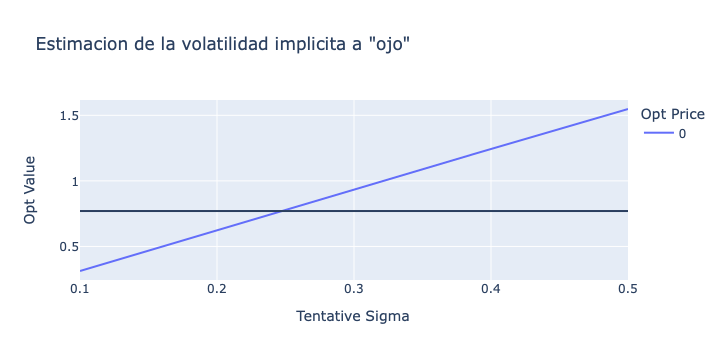

In [46]:
s0 = 8
K = 8
r = 0.02
q = 0.02
call_value = 0.77
opt_type = 'c'
sigma = np.linspace(0.1, 0.5, 29)
T = 1

call_opts = bls_option_price(s0, K, r, sigma, q, T, opt_type='c')
df_res = pd.DataFrame(call_opts, index=sigma)

fig = df_res.plot(
    title=f'Estimacion de la volatilidad implicita a "ojo"',
    labels=dict(index="Tentative Sigma", value="Opt Value", variable="Opt Price")
)
fig.add_hline(y=call_value)

fig.show()

##### Ceros de funciones

In [47]:
from scipy.optimize import fsolve

def get_implied_vol(sigma0, opt_value, s0, K, r, q, T, opt_type):
    f_error = lambda sigma, opt_value, s0, K, r, q, T, opt_type: abs(bls_option_price(s0, K, r, sigma, q, T, opt_type) - opt_value)
    res = fsolve(f_error, sigma0, args=(opt_value, s0, K, r, q, T, opt_type))
                                                                     
    return res[0]

In [48]:
get_implied_vol(0.2, call_value, s0, K, r, q, T, opt_type)

0.2467614465780882